# Aufgabe-I-Gezeitenvorhersage

## Allgemeines

Eine allgemeine Beschreibung der Laboraufgaben inklusive des Vorgehens, den Bewertungsrichtlinien und der Abgabe finden Sie  <a href="ML-allgemein.ipynb">hier</a>

## Datenquelle


* Laden Sie ihre Daten von http://141.72.190.207/ml_lab/I_gezeiten herunter
    * Die Daten sind geschützt. 
        * Sie müssen evtl. in einem Netzwerk der DHBW (z.B. WLAN, VPN, ...) angemeldet sein. 
        * Sie können sich auf der Webseite mit dem Benutzernamen dhbw und dem Zugangsnamen "ml_LaB_4$" anmelden. 
* Die Daten sind in einem anwendungsspezifischen Format gespeichert.
    * Sie finden evtl. Informationen über die Daten in einer "README" Datei. 
    * Finden Sie keine solche Datei sind die Daten selbst erklärend. 
    
    



## Aufgabe

Sie haben die Zeitreihen über Gezeiten in der irischen See. Verwenden Sie diese Zeitreihen und erstellen Sie eine Vorhersage für die Gezeitenhöhe an einem Ort und einer Zeit innerhalb der nächsten beiden Jahre.

* Verwenden Sie dazu ein tiefes neuronales Netzwerk!
* Vergleichen Sie die Ergebnisse des tiefen neuronalen Netzwerk mit einem traditionellen ML-Ansatz!


# Lösung

## Vorbereitungen

In [2]:
"""
Nötige Imports
"""
import datetime as dt
import pytz

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Csv einlesen und checken, ob es Nullwerte gibt. Diese gibt es nicht, also kann ohne Streichen von Zeilen/ Spalten oder Schätzen von fehlende Werten fortgefahren werden.

Die zweite Zeile der CSV (1. Index) kann beim Einlesen direkt übersprungen werden, da hier die Einheiten angegeben sind. Diese stellen im Dataframe aber keinen Nutzen dar.

In [3]:
df = pd.read_csv("data/gezeiten.csv", skiprows=[1])
df.head()
df.isnull().sum()

time               0
longitude          0
latitude           0
stationID          0
Water_Level        0
Water_Level_ODM    0
dtype: int64

# Datenvorverarbeitung

## Von Pandas mitgelieferter Ansatz, der StationID ein Label zuzuweisen.
Es gibt auch andere Möglichkeiten, aber dieser Weg erwies sich als sehr schnell und effizient.
Die nicht mehr benötigten Columns können gedropped werden:

- Station ID wurde durch StationIDLabel ersetzt, die Namen der Stationen sind aber weiterhin in Labels gespeichert.
- longitude und latitude sind hier nominale Werte, die sich auf die Station ID beziehen und dienen nicht der Vorhersage der Gezeiten.


In [4]:
"""
Von pandas mitgelieferter ansatz, der StationID ein Label zuzuweisen
"""
# str stationID wird durch int label ersetzt
df['StationID_Label'], labels = pd.factorize(df['stationID'])
print(labels)

# nicht mehr benötigte columns droppen
df = df.drop(columns=["stationID", "longitude", "latitude"])
df.head()

Index(['Achill_Island_MODELLED', 'Aranmore', 'Arklow_MODELLED', 'Ballycotton',
       'Ballyglass', 'Bray_Harbour_MODELLED', 'Carrigaholt_MODELLED',
       'Castletownbere', 'Clare_Island_MODELLED', 'Crosshaven_MODELLED',
       'Dingle_Harbour_MODELLED', 'Dublin_Port', 'Dundalk',
       'Dungarvan_MODELLED', 'Dunmore_East', 'Fenit_MODELLED', 'Galway_Port',
       'Howth', 'Inishmore', 'Killary_Harbour_MODELLED', 'Killybegs',
       'Kinsale_MODELLED', 'Kish_Bank_Lighthouse', 'Lahinch_MODELLED',
       'Letterfrack_MODELLED', 'Malin_Head', 'Rosslare_Port_MODELLED',
       'Skerries', 'Sligo', 'Tory_Island_MODELLED', 'Union_Hall_MODELLED',
       'Wexford', 'Wicklow_MODELLED'],
      dtype='object')


,time,Water_Level,Water_Level_ODM,StationID_Label
0,2017-01-01T00:10:00Z,1.34,-1.23,0
1,2017-01-01T00:20:00Z,1.30,-1.27,0
2,2017-01-01T00:30:00Z,1.26,-1.31,0
3,2017-01-01T00:40:00Z,1.23,-1.34,0
4,2017-01-01T00:50:00Z,1.22,-1.35,0


## Überprüfung der Korrelation beider "Water Level" Einheiten

Nach dem Sichten des Heads des Dataframe wird vermutet, dass sich die beiden Wasser Level
- Water Level und
- Water Level ODM (-> in Referenz zum Malin Ordnance Datum = Referenzwert, der durch die mittleren Gezeiten der Station Malin_Head berechnet wird)

nur um einen konstanten Wert unterscheiden. Das liegt daran, dass der Referenzwert, das Malin Ordnance Datum immer gleich ist. Dementsprechend ist auch der Offset zwischen beiden immer konstant.
Sollte das stimmen, kann eine der beiden Spalten vernachlässigt und gedroppt werden, da sie keinen weiteren Informationsgehalt bietet.

Da bei den über 150000 Werten pro Messstation auch kleinere Schwankungen auftreten, treten in der Differenz für jede Station selbst auch Schwankungen auf.
(Somit gibt es zwischen 2 und 4 verschiedene Offset-Werte). Da diese jedoch erst bei den 3. Nachkommastellen auftreten und diese für eine Vorhersage viel zu klein sind, werden die Wasser Level auf 2 Nachkommastellen gerundet.
Somit gibt es nur noch einen konstanten Wert, um den sich jeweils beide Werte pro Station unterscheiden.

Folgende Schlussfolgerungen lassen sich ziehen:

- Die Spalte "Water_Level_ODM" kann gedropped werden.
- Der Output des Models kann eindimensional sein.


In [4]:
df_water_level_comparison = df[['StationID_Label', "Water_Level", "Water_Level_ODM"]].copy()

df_water_level_comparison["Differenz"] = df_water_level_comparison["Water_Level"] - df_water_level_comparison["Water_Level_ODM"]
df_water_level_comparison = df_water_level_comparison.round(2)
df_water_level_comparison.groupby("StationID_Label")[["Differenz"]].nunique()

df = df.drop(columns=["Water_Level_ODM"])


## Interpolieren der Werte

Da es zwischen den MODELLED und nicht MODELLED Stationen Diskrepanzen in den Zeitstempeln gibt, werden beide folgend angepasst.
Dafür werden die Datensätze der nicht MODELLED Stationen von 6 Minuten Intervallen auf 10 Minuten interpoliert.
Folgend werden ebenfalls die interpolierten Werte als Float64 mit beispielsweise folgenden Werten abgespeichert:

1,2017-01-01 00:10:00+00:00,1.2349999999999999

Dies ist aber nicht notwendig und wird folgend ebenfalls zu Float16 konvertiert. Heraus kommt dann folgendes:

1,2017-01-01 00:10:00+00:00,1.235


In [5]:
df['time'] = pd.to_datetime(df['time'])
df_time_index = df.set_index("time")
df_interpolated = df_time_index.groupby("StationID_Label")[["Water_Level"]].resample('10min').mean().interpolate()
df_interpolated["Water_Level"] = df_interpolated["Water_Level"].astype(np.float16)


# Sichern der vorverarbeiteten Daten
Aufsplitten der großen CSV Datei in mehrere kleine, sortiert nach den Stationen.
Folgender Vorteile bietet sich hierbei:

Das Einlesen der großen CSV und darauf zu trainieren ist nicht effizient. Um den Trainingsprozess effizienter zu gestalten, wird zunächst auch nur auf einer Station trainiert. Funktioniert die Vorhersage für diese, kann das Model nachfolgend auch auf den gesamten Datensatz angewandt werden

Auffallend hierbei ist, dass es Datensätze mit 157681 oder 262801 Zeilen gibt.
Die Erklärung dafür ist einfach:

- MODELLED Stationen verfügen über weniger Daten, da diese im Abstand von 10 Minuten aufgenommen werden
- die anderen Stationen verfügen über mehr, da hier Zeitintervalle von 6 Minuten vorliegen.

In [6]:
station_groups = df_interpolated.groupby("StationID_Label")

for station_id, data in station_groups:
    filename = f"splitted_interpolated/{station_id}-{labels[station_id]}.csv"
    data.to_csv(filename, index=True)

StationID_Label
0     157681
1     157681
2     157681
3     157681
4     157681
5     157681
6     157681
7     157681
8     157681
9     157681
10    157681
11    157681
12    157681
13    157681
14    157681
15    157681
16    157681
17    157681
18    157681
19    157681
20    157681
21    157681
22    157681
23    157681
24    157681
25    157681
26    157681
27    157681
28    157681
29    157681
30    157681
31    157681
32    157681
dtype: int64

In [8]:
"""
Erzeugen einer großen, vorverarbeiteten CSV Datei:
"""
filename = f"data/preprocessed_interpolated.csv"
df_interpolated.to_csv(filename, index=True)


# Training verschiedener Modelle

Im Paper [Long Short-Term Memory Recurrent Neural Network for Tidal Level Forecasting](https://ieeexplore.ieee.org/document/9169644)
von Cheng-Hong Yang, Chih-Hsien Wu und Chih-Min Hsieh, wird die Eignung folgender Modelle für die Gezeitenvorhersage dargelegt.

1. Ein klassisches Machine Learning Model - Support Vector Regression
2. Ein Recurrent Neural Network
3. Ein Long Short-Term Memory Recurrent Neural Network


Diese erzielten (Die SVR kann mit tiefen neuronalen Netzen nicht mithalten) und erzielen nachweislich die besten Ergebnisse für die Gezeitenvorhersage.
## Trainingsprozess für ein Single-Output LSTM-Model für eine Station

In [1]:
import datetime as dt
import pytz

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

### Einlesen einer Datei einer Station für das Training eines Modells für diese.
Zunächst wird die vorverarbeitete CSV Datei für eine Station eingelesen.
Dabei müssen die Timestamps in numerische Werte umgeformt werden.
Als Referenz dafür dient das Unix-Format. So wird jeder Timestamp auf die vergangene Anzahl an Sekunden nach dem zugehörigen Referenzwert gemapped.

Außerdem wird die Spalte Station_ID nicht mit in das fertige Dataframe gezogen, da diese für das Training zu einer Station überflüssig ist.

In [2]:
df = pd.read_csv("splitted_interpolated/1-Aranmore.csv")
df['time'] = pd.to_datetime(df['time'])

df['timeinseconds'] = df['time'].map(pd.Timestamp.timestamp)

df = df[['timeinseconds', "Water_Level"]]

time = df['timeinseconds'].values
waterlevel = df['Water_Level'].values

Folgend werden die Daten in Trainings- und Testdaten in Numpy Arrays aufgeteilt.
Die Aufteilung erfolgt hier zu 90% in Trainings- und 10% in Testdaten. Die Reihenfolge wird hierbei nicht geshuffled.

In [3]:
data_length = len(df)
X_train = time[0:int(data_length*0.9)]
y_train = waterlevel[0:int(data_length*0.9)]

X_test = time[int(data_length*0.9):]
y_test = waterlevel[int(data_length*0.9):]

n_features = 1

train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))

Plot der Trainings- und Testdatensequenzen:

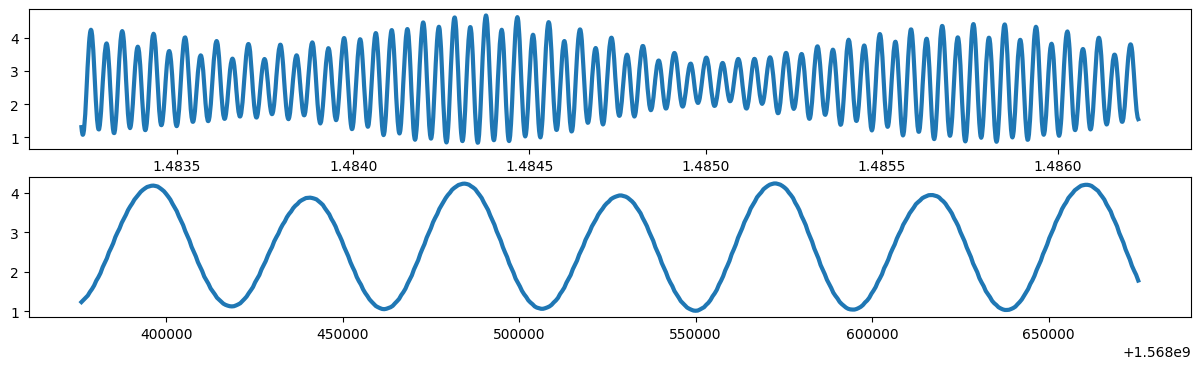

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(15, 4))
axs[0].plot(X_train[:5000], y_train[:5000],  lw=3, label='test data')
axs[1].plot(X_test[:500], y_test[:500],  lw=3, label='test data')

plt.show()

Um den Input dem folgenden Model anzupassen, wurde der TimeseriesGenerator von keras verwendet:

In [6]:
look_back  = 72

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

Beim Training eines LSTM-Models für die Station Aranmore mit folgendem Aufbau...

In [ ]:
#do not execute
look_back = 72
n_epochs = 25
n_neurons = 4
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(look_back, 1)))
model.add(Dense(1))

model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = model.fit(train_generator, epochs=10,
                        verbose=1)

model.model.save(f"single/1-LSTM-4-Dense1-aranmore-{n_epochs}epochs-{look_back}lookback.h5")

... ergaben sich für eine variierende Anzahl von Epochen folgende Werte. Der Input hierbei waren Windows einer Größe von 72 Datenpunkten, also einem halben Tag:

- Loss für 10 Epochen (35 min Trainingszeit): 0,000115 MSE
- Loss für 25 Epochen (90 min Trainingszeit): 0,000089 MSE
- Loss für 50 Epochen (175 min Trainingszeit): 0,0000416 MSE
- Loss für 100 Epochen (335 min Trainingszeit) 0,00003 MSE

Dies sieht auf den ersten Blick sehr gut aus. Warum das jedoch nicht aussagekräftig ist, wird folgend erklärt.

###  Laden des Models und Predicten der Testdaten

In [8]:
model = tf.keras.models.load_model('single/1-LSTM-4-Dense1-aranmore-10-epochs.h5')

test_predictions = model.predict(test_generator)

1570/1570 [==============================] - 5s 3ms/step

Plotten der Testdaten, und deren zugehörigen Predictions:

C:\Users\benja\AppData\Local\Temp\ipykernel_11680\630082231.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


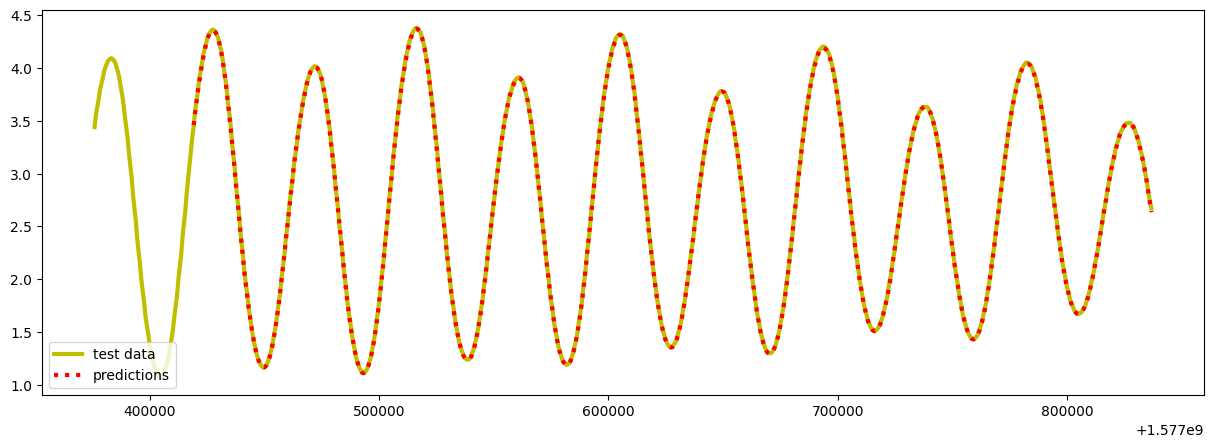

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(X_test[15000:], y_test[15000:], lw=3, c='y', label='test data')
ax.plot(X_test[15072:], test_predictions[15000:], lw=3, c='r',linestyle = ':', label='predictions')
ax.legend(loc="lower left")
fig.show();

Auch hier sieht das Ergebnis sehr vielversprechend aus. Was sich hier aber zeigt ist, dass die Daten eher auswendig gelernt wurden. Das Modell generalisiert nicht genug.

### Extrapolation von 180 neuen Werten

Folgend soll gezeigt werden, wie gut das Model für die Vorhersage funktioniert:
Dafür wird eine Extrapolation der letzten 180 Werte durchgeführt.

In [12]:
extrapolation = list()
#lookback 72: 15517:15589
#lookback 144: 15445:15589
seed_batch = y_test[15517:15589].reshape((1, look_back, n_features))
current_batch = seed_batch

for i in range(180):
    predicted_val = model.predict(current_batch, verbose=0)[0]
    extrapolation.append(predicted_val)
    current_batch = np.append(current_batch[:,1:,:],[[predicted_val]], axis=1)

Diese Werte sollen folgend auch veranschaulicht werden:

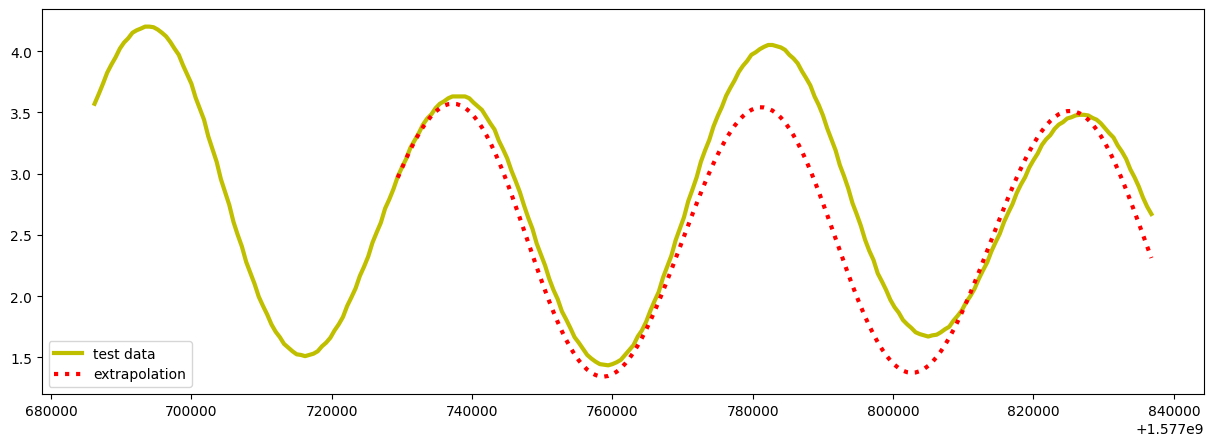

In [13]:
x = np.arange(1577836800,1577836800 + 600*180,600)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#ax.plot(X_train,y_train, lw=2, label='train data')
ax.plot(X_test[-252:],y_test[-252:], lw=3, c='y', label='test data')
ax.plot(X_test[-180:], extrapolation, lw=3, c='r',linestyle = ':', label='extrapolation')
ax.legend(loc="lower left")
plt.show();



Es zeigt sich, dass das Model zwar die Periodizität relativ gut abstrahieren, jedoch in keiner Weise die Amplituden der Gezeiten darstellen kann.

Als Vergleich können hier sehr gut die [Realtime Observations](http://www.marine.ie/site-area/data-services/real-time-observations/tidal-observations-1?instrumentname=Aranmore%20Island%20-%20Leabgarrow)
gezogen werden.

Ebenfalls ist auch die Vorhersage neuer Werte extrem langsam. Die eigens erstellte Klasse TidePredictionSingleOutput
gibt auf eine Eingabe einer Station und eines Timestamps zwar eine Prediction wieder. Diese ist aber nur für die ersten zwei Tage des Jahres 2020 relativ genau.

Außerdem dauert die Vorhersage extrem lang, führt bei einem zu weit entfernten TimeStamp zu einer extrem langen Berechnungszeit und teilweise sogar Bufferoverflows.
Das liegt vor allem daran, dass das Modell Single Outputs hat und dementsprechend nicht effizient ist.

Deshalb wurde dieser Ansatz als nicht ausreichend festgestellt.

In [15]:
from LstmManager import TidePredictionSingleOutput

pred1 = TidePredictionSingleOutput(1, "2020-01-10 08:00:00+00:00")
pred = pred1.predict_timestamp()

The estimated Water Level for Station 1 is 1.9137845039367676 m.


# Trainingsprozess für ein Multi-Output LSTM-Model für eine Station

Aufgrund der Ungenauigkeit und der langen Berechnungszeit soll nun eine Alternative für das Single-Step LSTM Model dargestellt werden.
Die Grundlagen sind hier wieder ähnlich:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping
from WindowGenerator import generate_window, multi_step_plot, plot_train_history
from sklearn.preprocessing import MinMaxScaler
batch_size = 256
buffer_size = 10000
train_val_split = 140000
train_test_split = 150000
patience = 5

seed = 13
tf.random.set_seed(seed)

Auch hier werden zuerst die Daten eingelesen:

In [2]:
df = pd.read_csv("splitted_interpolated/2-Arklow_MODELLED.csv")
df['time'] = pd.to_datetime(df['time'])

df['timeinseconds'] = df['time'].map(pd.Timestamp.timestamp)

df = df[['timeinseconds', "Water_Level"]]

time = df['timeinseconds'].values
dataset = df['Water_Level']
dataset.index = df["timeinseconds"]

dataset = dataset.values

MinMaxScalen des Water_Levels.

In [3]:
train_data = dataset[:train_val_split].reshape(-1, 1)
test_data = dataset[train_val_split:].reshape(-1, 1)

minmaxscaler = MinMaxScaler()
train_data = minmaxscaler.fit_transform(train_data)
test_data = minmaxscaler.transform(test_data)
dataset = np.concatenate((train_data, test_data))


Um die Erzeugung der Windows hier passend zu machen werden folgende Variablen deklariert:
- look_front (Output des Models, wie viele Timesteps sollen vorausgesagt werden)
- look_back (Historie, wie viele Timesteps kann das Model zurückschauen)

In [9]:
look_front = 144
look_back = 720


x_train_multi, y_train_multi = generate_window(dataset, dataset, 0,
                                                 train_val_split, look_back,
                                                 look_front)
x_val_multi, y_val_multi = generate_window(dataset, dataset,
                                             train_val_split, train_test_split, look_back,
                                             look_front)

x_test_multi, y_test_multi = generate_window(dataset, dataset,
                                                   train_test_split, None, look_back,
                                                   look_front)

print(x_train_multi.shape,
      y_train_multi.shape,
      'Single window of past history (lookback): {}'.format(x_train_multi[0].shape),
      'Target Water Level to predict (lookfront): {}'.format(y_train_multi[0].shape),
      sep='\n')

(139280, 720, 1)
(139280, 144, 1)
Single window of past history (lookback): (720, 1)
Target Water Level to predict (lookfront): (144, 1)


Nun wird der Input für das neue Modell angepasst. Dabei wird in Trainings-, Validierungs- und Testdaten unterteilt.


In [10]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

test_data_multi = tf.data.Dataset.from_tensor_slices((x_test_multi, y_test_multi))
test_data_multi = test_data_multi.batch(batch_size).repeat()

Probeweise kann die in einem Step begutachtete Historie (Lookback) und der Lookfront veranschaulicht werden:

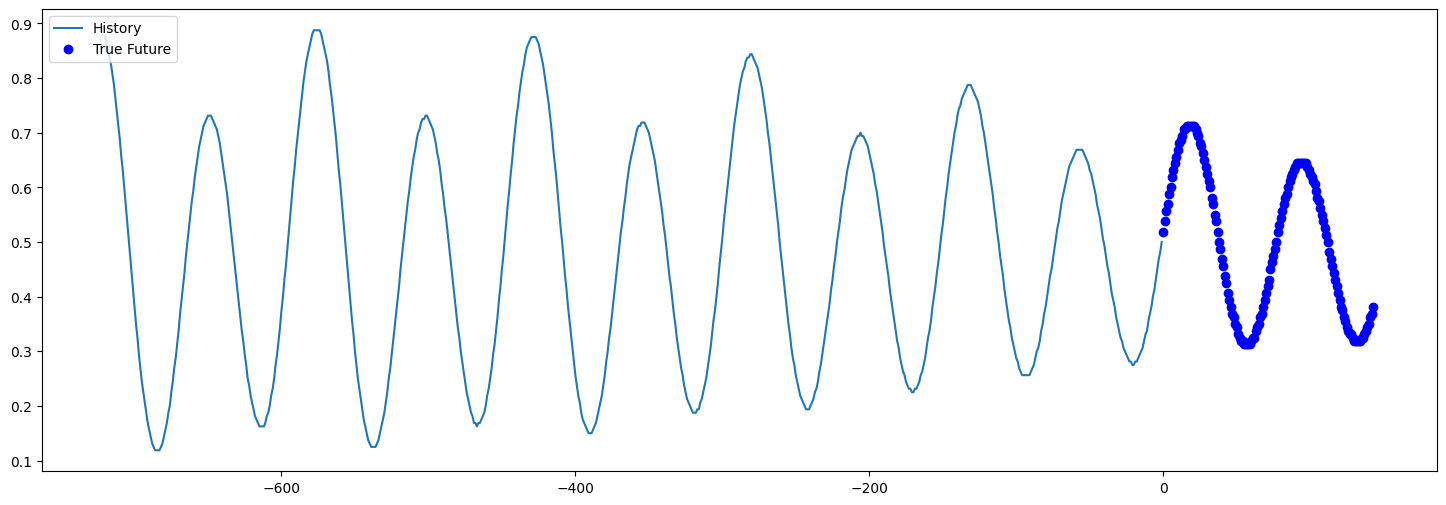

In [11]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
#do not execute
neurons_first_layer = 128
neurons_second_layer = 32
epochs = 50
evaluation_interval = 200
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(neurons_first_layer,
                               return_sequences=True,
                               input_shape=(144, 1)))
model.add(tf.keras.layers.LSTM(neurons_second_layer))
model.add(tf.keras.layers.Dense(look_front))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
print(model.summary())

history = model.fit(train_data_multi,
                    epochs=epochs,
                    steps_per_epoch=evaluation_interval,
                    validation_data=val_data_multi,
                    validation_steps=evaluation_interval,
                    callbacks=[early_stopping],
                    verbose=0)

model.save(f"hdf5/1-{look_back}-LSTM{neurons_first_layer}-LSTM{neurons_second_layer}relu-Dense-{look_front}-aranmore-{epochs}epochs.h5")

plot_train_history(history, f"hdf5/1-{look_back}-LSTM{neurons_first_layer}-LSTM{neurons_second_layer}relu-Dense-{look_front}-aranmore-{epochs}epochs.h5")

### Evaluation verschiedener Architekturen.
Die Namen der folgenden Modelle sind wie folgt aufgebaut:

"{StationID_Label}-{lookback}-LSTM{NeuronsFirstLayer}-LSTM{NeuronsSecondLayer}-Dense{lookfront(NeuronsDenseLayer)}-{Epochs}epochs.h5}

Die entsprechenden Einstellungen für das Training sind den Namen der jeweiligen Modelle zu entnehmen. Bei verschiedenen Konfigurationen und Einstellungen der Parameter ergaben sich die folgenden Ergebnisse:

Für das Modell *1-720-LSTM64-LSTM32-Dense72-25epochs.h5* ergab sich folgendes:

- Epoch 18/25
200/200 [==============================] - 15s 77ms/step - loss: 0.0167 - val_loss: 0.0165
Test loss for model /multioutput_models/1-720-LSTM64-LSTM32-Dense72-25epochs.h5 : 0.01506926491856575

Dies ist zwar ein relativ guter Loss, für eine ausreichende Vorhersage ist dieser zu hoch. Auch hat das Model durch den Callback bei der 18. Epoche abgebrochen.

Für das Modell *1-720-LSTM64-LSTM32-Dense144-25epochs.h5* mit einem erhöhten Lookfront ergab sich folgendes:

- Epoch 25/25
200/200 [==============================] - 16s 78ms/step - loss: 0.0091 - val_loss: 0.0116
Test loss for model /multioutput_models/1-720-LSTM64-LSTM32-Dense144-25epochs.h5 : 0.009801153093576431

Offensichtlich ist der größere Lookfront von einem Tag schon selbst besser, als der von 12h, aber hier hat die Zahl der Epochen nicht ausgereicht, um das Model fertig zu trainieren. Ein Bild der Testvorhersagen findet man [hier](bilder/model_vergleich/1-720-LSTM64-LSTM32-Dense144-25epochs.png).

Aus diesem Grund wurde die Zahl der Epochen auf 50 erhöht. Somit ergab sich für das Model *1-720-LSTM64-LSTM32-Dense144-50epochs.h5*:

- Epoch 37/50
200/200 [==============================] - 16s 79ms/step - loss: 0.0077 - val_loss: 0.0086
Test loss for model /multioutput_models/1-720-LSTM64-LSTM32-Dense144-50epochs.h5 : 0.007123385556042194

Hier ist der Callback nach 37 Epochen eingetreten, das Modell performt zwar sehr gut, jedoch wird anhand des Validation Losses sichtbar, dass sich hier um eine Unteranpassung handeln könnte. Ein Bild der Testvorhersagen findet man [hier](bilder/model_vergleich/1-720-LSTM64-LSTM32-Dense144-50epochs.png).

Somit wurden im nächsten Schritt die Neuronen für das Model *1-720-LSTM128-LSTM32-Dense144-50epochs.h5* variiert.:

- Epoch 46/50
200/200 [==============================] - 23s 115ms/step - loss: 0.0059 - val_loss: 0.0068
Test loss for model /multioutput_models/1-720-LSTM128-LSTM32-Dense144-50epochs.h5 : 0.0061964611522853374

Auch hier gibt es zwar wieder eine scheinbare Unteranpassung, der Testloss ist jedoch so gut wie bisher noch nicht. Ein Bild der Testvorhersagen findet man [hier](bilder/model_vergleich/1-720-LSTM128-LSTM32-Dense144-50epochs.png).

Um den Lookfront auszureizen wurde auch nochmal ein Lookfront von 288 (2 Tagen) für das Model *1-720-LSTM128-LSTM32-Dense288-50epochs.h5* getestet:

- Epoch 42/50
200/200 [==============================] - 23s 116ms/step - loss: 0.0072 - val_loss: 0.0105
Test loss for model /multioutput_models/1-720-LSTM128-LSTM32-Dense288-50epochs.h5 : 0.008444879204034805

Da hier die Evaluierung jedoch schlechtere Ergebnisser ergab, als zuvor, wurde dieser Ansatz wieder verworfen und sich auf das Model *1-720-LSTM128-LSTM32relu-Dense144-50epochs.h5* geeinigt. Ein Bild der Testvorhersagen für das verworfene Model mit dem Lookfront von 288 findet man [hier](bilder/model_vergleich/1-720-LSTM128-LSTM32-Dense288-50epochs.png).

Auf Basis dessen wurden demzufolge für jede Station ein Modell trainiert und kann nun über die Klasse TidePredictionMultiOutput genutzt werden.


### Beispieldaten
Laden eines gesicherten Models

In [12]:
model = tf.keras.models.load_model("models_720_lookback/2-720-LSTM128-LSTM32-Dense144-50epochs.h5")

Vorhersagen der Testdaten:

Test loss for your model: 0.008553100749850273
8/8 [==============================] - 1s 156ms/step


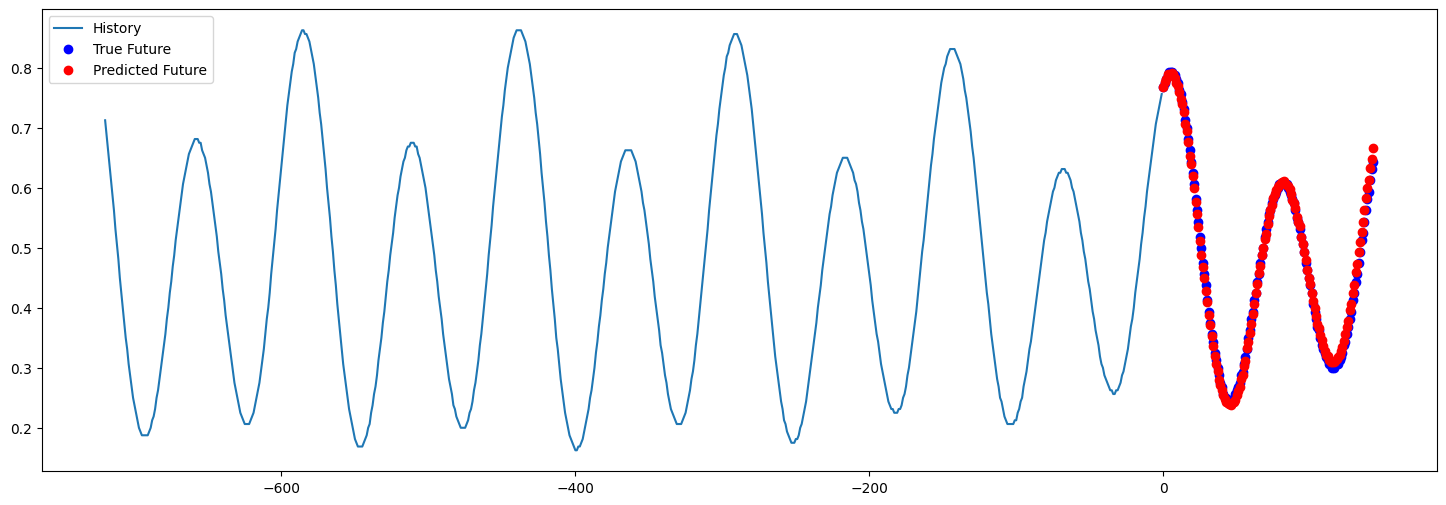

In [14]:
test_loss = model.evaluate(test_data_multi, steps=len(x_test_multi) // batch_size, verbose=0)
print(f"Test loss for your model: {test_loss}")
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], model.predict(x)[0])

Wie man erkennt, sagt das Model die Testdaten mit einem sehr geringen Loss voraus. Auch der Plot ist gut predicted. Zudem ist die Vorhersagezeit wesentlich geringer:

In [3]:
from LstmManager import TidePredictionMultiOutput

pred1 = TidePredictionMultiOutput(1, "2020-01-06 13:30:00+00:00")
pred = pred1.predict_timestamp()

The estimated Water Level for Station 1 is 3.580078125 m.


Die finale Implementierung der Prediction befindet sich in der Klasse TidePredictionMultiOutput. Bei einer Vorhersage, weit in der Zukunft, dauert auch diese Berechnung sehr lang, ist aber wesentlich schneller, als die SingleOutputmethode

Hier ist zu beachten, dass es sich um eine BestCase Implementierung handelt. Es sollten keine Experimente mit älteren Zeitstempeln o. ä. gemacht werden. Sie dient nur dem normalen Fall und kann in die Zukunft vorhersagen.

Allgemein sind die Vorhersagen mit Vorsicht zu genießen, da der Trainingsdatensatz bereits aus vorhergesagten Werten bestand, wie man aus Beschreibung des Datensatzes auf der Webseite [Kaggle.com](https://www.kaggle.com/datasets/arjunbhaybhang/marine-institute-tide-prediction-dataset) herauslesen kann.